In [431]:
%reset -f

In [432]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import math as math
from scipy.integrate import solve_ivp

## Energy Balance Reboiler

df_Me = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_methanol.xlsx')
df_Iso = pd.read_excel(r'/Users/caterina/Documents/TU:e/CPT/Process Tech/python intro/Cp_isopropanol.xlsx')



In [433]:
# Getting data from file and making fitted line
Temp_list_Me = df_Me['Temperature'].values.tolist()
Cp_list_Me = df_Me['Cp'].values.tolist()
a_Me, b_Me, c_Me = np.polyfit(Temp_list_Me, Cp_list_Me, deg=2)

'''plt.plot(Temp_list_Me, Cp_list_Me, "o")
plt.plot(Temp_list_Me, np.polyval((a_Me, b_Me, c_Me),Temp_list_Me), "-")
plt.xlabel('T[K]')
plt.ylabel('Cp') 
plt.title('Methanol heat capacity')
plt.show()'''

# Heat Capacity Isopropanol

# Getting data and making fitted line
Temp_list_Iso = df_Iso['Temp'].values.tolist()
Cp_list_Iso = df_Iso['Cp'].values.tolist()
a_Iso, b_Iso, c_Iso = np.polyfit(Temp_list_Iso, Cp_list_Iso, deg=2)
Temps_Iso_model = np.linspace(-20, 85, 22)
Temps_Iso_model_K  = [x+273.15 for x in Temps_Iso_model] # convert to Kelvin

'''plt.plot(Temp_list_Iso, Cp_list_Iso, "o")
plt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")
plt.xlabel('T[K]') # label on the x axis
plt.ylabel('Cp') # label on the y axis
plt.title('Isopropanol heat capacity')
plt.show()'''

'plt.plot(Temp_list_Iso, Cp_list_Iso, "o")\nplt.plot(Temps_Iso_model_K, np.polyval((a_Iso, b_Iso, c_Iso), Temps_Iso_model_K), "-")\nplt.xlabel(\'T[K]\') # label on the x axis\nplt.ylabel(\'Cp\') # label on the y axis\nplt.title(\'Isopropanol heat capacity\')\nplt.show()'

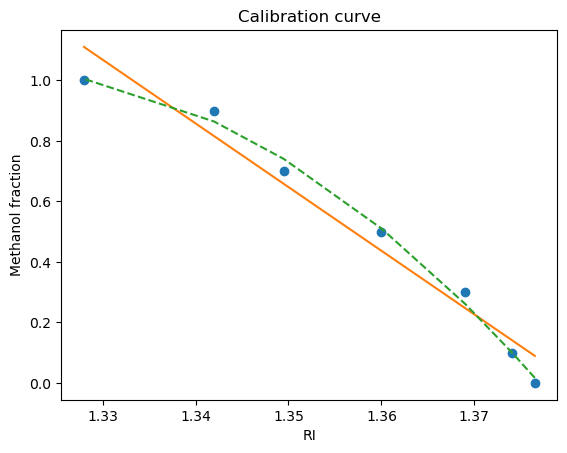

0.5105995532411498


In [434]:
# Refractive Index Calibration Curve

#Measurements
Me_fraction = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
RI = [1.3765, 1.374, 1.369, 1.360, 1.3495, 1.342, 1.328]

#fitting line at multiple degrees
Cal_a_fit, Cal_b_fit = np.polyfit(RI, Me_fraction, deg=1)
Cal_a_fit2, Cal_b_fit2, Cal_c_fit2 = np.polyfit(RI, Me_fraction, deg=2)

plt.plot(RI, Me_fraction,"o")
plt.plot(RI, np.polyval((Cal_a_fit, Cal_b_fit), RI),"-")
plt.plot(RI, np.polyval((Cal_a_fit2, Cal_b_fit2, Cal_c_fit2), RI), "--")
plt.xlabel("RI")
plt.ylabel("Methanol fraction")
plt.title('Calibration curve')
plt.show()

def Calibration(RI):
    Me_ratio = RI**2 * Cal_a_fit2 + RI*Cal_b_fit2 + Cal_c_fit2
    return Me_ratio

#use calibration function to get the methanol fraction
Me_frac = Calibration(1.36)
print(Me_frac)

In [435]:
# Constants
dH_vap_Me = 37340 #Enthalpy of vaporisation methanol at boiling point [J/mol]
dH_vap_iso = 44000 #Enthalpy of vaporisation isopropanol at boiling point [J/mol]
eff = 1 #640/751 # Heater efficiency (around 0.85)
T0 = 298 #K
V  = 0.01 # Volume of mixture in reboiler [m^3]
Iso_frac = 1-Me_frac # Mole fraction isopropanol
dens_Me = 792 #kg/m3
dens_Iso = 786 #kg/m3
M_Me = 32.02 #g/mol
M_Iso = 60.1 #g/mol
Vm_Me = 40.75 # molar volume methanol [cm^3/mol]
Vm = (M_Me/1000/dens_Me)*Me_frac + (M_Iso/1000/dens_Iso)*(1-Me_frac) # Molar volume of mixture [m^3/mol]
n_total = V/Vm # Total number of moles in mixture
n_Me = Me_frac*n_total # Number of moles of methanol
n_Iso = Iso_frac*n_total # Number of moles of isopropanol
dens_mix = (n_Me*M_Me + n_Iso*M_Iso)/V # Density of mixture [kg/m^3]
M_mix = (n_Me*M_Me + n_Iso*M_Iso)/1000 #kg/mol
power_percent = 0.7
power = eff*power_percent*2000 #J/s (maximum power is 2kW)
p_atm = 101325  # Atmospheric pressure in Pa
R = 8.3144598          # Gas constant J/molK
A = 1                  # Evaporation surface area m2


In [436]:
k_me = 1.34  #m/s 
k_iso = 1.27 #m/s

In [437]:
#Heat transfer coefficients 

Cp_L_me = 87.71   #J/mol.K
Cp_v_me = 47.99   #J/mol.K
Cp_L_iso = 176.16 #J/mol.K
Cp_v_iso = 110.29 #J/mol.K

#Total liquid avg heat transfer coeff in J/mol.K
def Cp_L(x_me, x_iso):
    Cp_L = x_me*Cp_L_me + x_iso*Cp_L_iso
    return Cp_L

#Total vapor avg heat transfer coeff in J/mol.K
def Cp_v(y_me, y_iso):
    Cp_v = y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_v

#Total (liquid+vapor) avg heat transfer coeff in J/mol.K
def Cp_tot(Nme_L,Niso_L,Nme_v,Niso_v):
    x_me = Nme_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    x_iso = Niso_L/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_me = Nme_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    y_iso = Niso_v/(Nme_L+Niso_L+Nme_v+Niso_v)
    Cp_tot = x_me*Cp_L_me + x_iso*Cp_L_iso + y_me*Cp_v_me + y_iso*Cp_v_iso
    return Cp_tot




# Vapor pressure for both compounds in Pa 
def p0_me(T):
    #Antonie constants-methanol 
    A_me = 8.08097
    B_me = 1582.27
    C_me = 239.7
    #vapour pressure
    anto_me = A_me - (B_me/(T+C_me))
    p0_me_mmHg = (math.pow(10,anto_me)) 
    p0_me = p0_me_mmHg/0.00750062   #Pa

    return p0_me   


def p0_iso(T):
    #Antoine constants isopropanol
    A_iso = 8.00308
    B_iso =	1505.52
    C_iso = 211.6
    #vapour pressure 
    anto_iso = A_iso - (B_iso/(T+C_iso))
    p0_iso_mmHg = (math.pow(10,anto_iso))
    p0_iso = p0_iso_mmHg/0.00750062   #Pa
    
    return p0_iso


In [438]:
params = {
    'Me_frac': Me_frac,   
    'n_total': n_total,
    'power': power,
    'A': A, 
    'R': R,        # Gas constant
    'k_me': k_me,  # mass coefficient methanol,
    'k_iso': k_iso, # mass coefficient isopropanol
    'p_atm': p_atm,
    'dH_vap_Me': dH_vap_Me
}

In [439]:
def modelODE(t,N, params):
    A = params['A']
    k_me = params['k_me']
    k_iso = params['k_iso']
    p_atm = params['p_atm']
    Me_frac = params['Me_frac']
    power = params['power']

    T_ref = 293.15 

    Nme_L = N[0]
    Niso_L = N[1]
    Nme_v = N[2]
    Niso_v = N[3]
    N_L_tot = Nme_L + Niso_L 
    N_v_tot = Nme_v + Niso_v
    N_tot = N_L_tot + N_v_tot
    T = N[4]
    
    #mol fractions 
    y_me = Nme_v/(N_v_tot)
    x_me = Nme_L/(N_L_tot)
    y_iso = Niso_v/(N_v_tot)
    x_iso = Niso_L/(N_L_tot)
    
    dNdt = np.zeros(5)

    #p_tot = y_me*p0_me(T) + y_iso*p0_iso(T)
    p_tot = 101325
    evap_me = 0.0001*A*((x_me*p0_me(T) - p_tot*y_me)/(R*T))
    evap_iso = 0.0001*A*((x_iso*p0_iso(T) - p_tot*y_iso)/(R*T))

    print(evap_me, evap_iso)

    dNdt[0] = -evap_me      #meL
    dNdt[1] = -evap_iso     #isoL
    dNdt[2] = evap_me       #meV
    dNdt[3] = evap_iso      #isoV
    dNdt[4] = (1/(Cp_L(x_me,x_iso)*N_L_tot)) * (- ((evap_me*dH_vap_Me) + (evap_iso*dH_vap_iso))) #temperature equation
    
    return dNdt

In [440]:
N_initial = [115, 115, 0.0001, 0.0001, 293] # meL isoL meV isoV
tspan = np.linspace(0, 3000, 1000)
t0, tf = 0, 10000
sol = solve_ivp(modelODE, (t0, tf), N_initial,args = (params,), method='Radau')
#N = odeint(modelODE, N_initial, tspan, args = (params,))

0.3509878578594972 0.2841141742011829
0.35096179956773343 0.28414000810982887
0.35098785522893944 0.2841141763334929
0.3509878604900549 0.2841141720688729
0.3509878578440028 0.28411417421667734
0.3509878578749916 0.2841141741856885
0.35098784329823235 0.28411416142280216
0.3509878578594972 0.2841141742011829
0.3509878578594972 0.2841141742011829
0.3509878578594972 0.2841141742011829
0.3508389985291664 0.2842595543417819
0.3507890500773984 0.28429850861001466
0.3507804311948809 0.2842991582603224
0.3507729849944496 0.28430660855173745
0.3507662404163447 0.2843066992917369
0.35075051083975267 0.2843014055988945
0.3507410529945203 0.2842956270195564
0.3507660606088289 0.2843068792252475
0.35074973268264054 0.2843021846726026
0.35073980730363413 0.2842968746074801
0.3507397329780791 0.2842969490462216
0.3507153669543042 0.2842806937840405
0.3506429891756075 0.2842247463602199
0.3505913943568238 0.2841833588309002
0.3507153533174459 0.28428070745416134
0.3506429617383979 0.2842247739429416


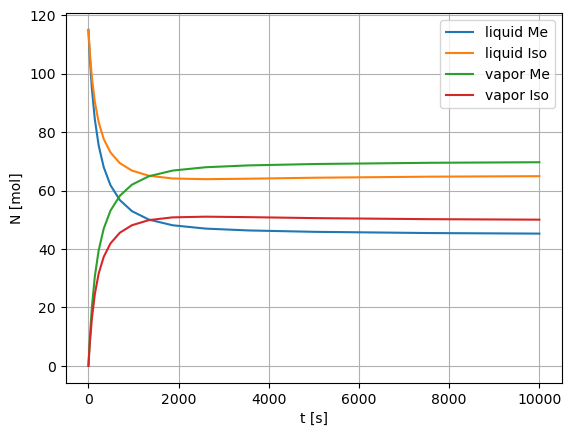

In [441]:
#plt.plot(tspan, N[:,0], label = 'liquid Me')
#plt.plot(tspan, N[:,1], label = 'liquid Iso')
#plt.plot(tspan, N[:,2], label = 'vapor Me')
#plt.plot(tspan, N[:,3], label = 'vapor Iso')

plt.plot(sol.t, sol.y[0], label = 'liquid Me')
plt.plot(sol.t, sol.y[1], label = 'liquid Iso')
plt.plot(sol.t, sol.y[2], label = 'vapor Me')
plt.plot(sol.t, sol.y[3], label = 'vapor Iso')

plt.legend()
plt.xlabel("t [s]")
plt.ylabel("N [mol]")
plt.grid()
plt.show()

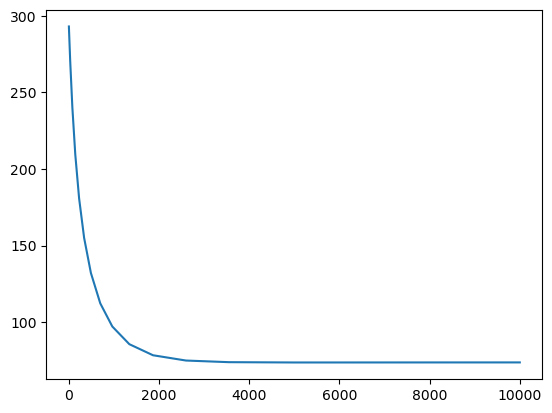

In [442]:
plt.plot(sol.t,sol.y[4])